In [139]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import FocalLoss, f1
from wrn4 import *

In [140]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')

# TRAIN64 = Path('train64/')
# TRAIN128 = Path('train128/')
# TRAIN256 = Path('train256/')
# TRAIN512 = Path('train512/')
# TEST256 = Path('test256/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [141]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    path=str(path)
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(path+ '_red.png', flags)
    blue = cv2.imread(path+ '_blue.png', flags)
    green = cv2.imread(path+ '_green.png', flags)
    yellow = cv2.imread(path+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im/255).float())


In [60]:
fname = train_names[0]

In [63]:
%time im = open_image4d(TRAIN/fname)

CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 17.6 ms


In [64]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

## Custom DL

In [46]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, label_delim=' ', fn_col=0, label_col=1)
test_fnames, _ = _df_to_fns_labels(sample_sub, fn_col=0, label_col=1)

In [47]:
classes = uniqueify(np.concatenate(labels))

In [180]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [50]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [145]:
train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [78]:
train_dl = DataLoader(train, 1, collate_fn=data_collate)

In [79]:
x,y = next(iter(train_dl))

In [80]:
x,y

(tensor([[[[0.0431, 0.0235, 0.0078,  ..., 0.0000, 0.0235, 0.0039],
           [0.0196, 0.1255, 0.0745,  ..., 0.0078, 0.0039, 0.0118],
           [0.0000, 0.0078, 0.1020,  ..., 0.0196, 0.0078, 0.0196],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0941, 0.0471, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.2824, 0.0706],
           [0.0000, 0.0000, 0.0000,  ..., 0.1529, 0.0706, 0.0902]],
 
          [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0039, 0.0157],
           [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
           [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
           [0.0000, 0.0000, 0.0000,  ..., 0.0353, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0196, 0.0196]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.00

In [82]:
n = len(train.y); n

25023

## Oversampling

In [83]:
from torch.utils.data.sampler import WeightedRandomSampler

In [168]:
count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
               45,    28,  1093,   688,   537,  1066,    21,   530,   210,
               902,  1482,   172,  3777,   802,  2965,   322,  8228,   328, 11])
weights = 1/np.sqrt(count)

In [169]:
weights

array([0.00881 , 0.028239, 0.016618, 0.02531 , 0.023199, 0.019948, 0.031497, 0.018824, 0.137361, 0.149071, 0.188982,
       0.030248, 0.038125, 0.043153, 0.030628, 0.218218, 0.043437, 0.069007, 0.033296, 0.025976, 0.076249, 0.016271,
       0.035311, 0.018365, 0.055728, 0.011024, 0.055216, 0.301511])

In [170]:
def sampled_dl(dataset, bs=1):
    targets = dataset.y
    samples_weight  = array([weights[targets[i]].sum() for i in range(len(targets))])
    samples_weight = torch.from_numpy(samples_weight)
    wrs = WeightedRandomSampler(samples_weight, len(targets))
    return DataLoader(train, bs, collate_fn=data_collate, sampler=wrs)

In [186]:
datasets = [train,val]
datasets = transform_datasets(*datasets, tfms=tfms, size=24)

In [202]:
train_dl, val_dl = sampled_dl(datasets[0],1), sampled_dl(datasets[1], 1)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


In [203]:
db = ImageDataBunch(train_dl, val_dl, tfms = norm)

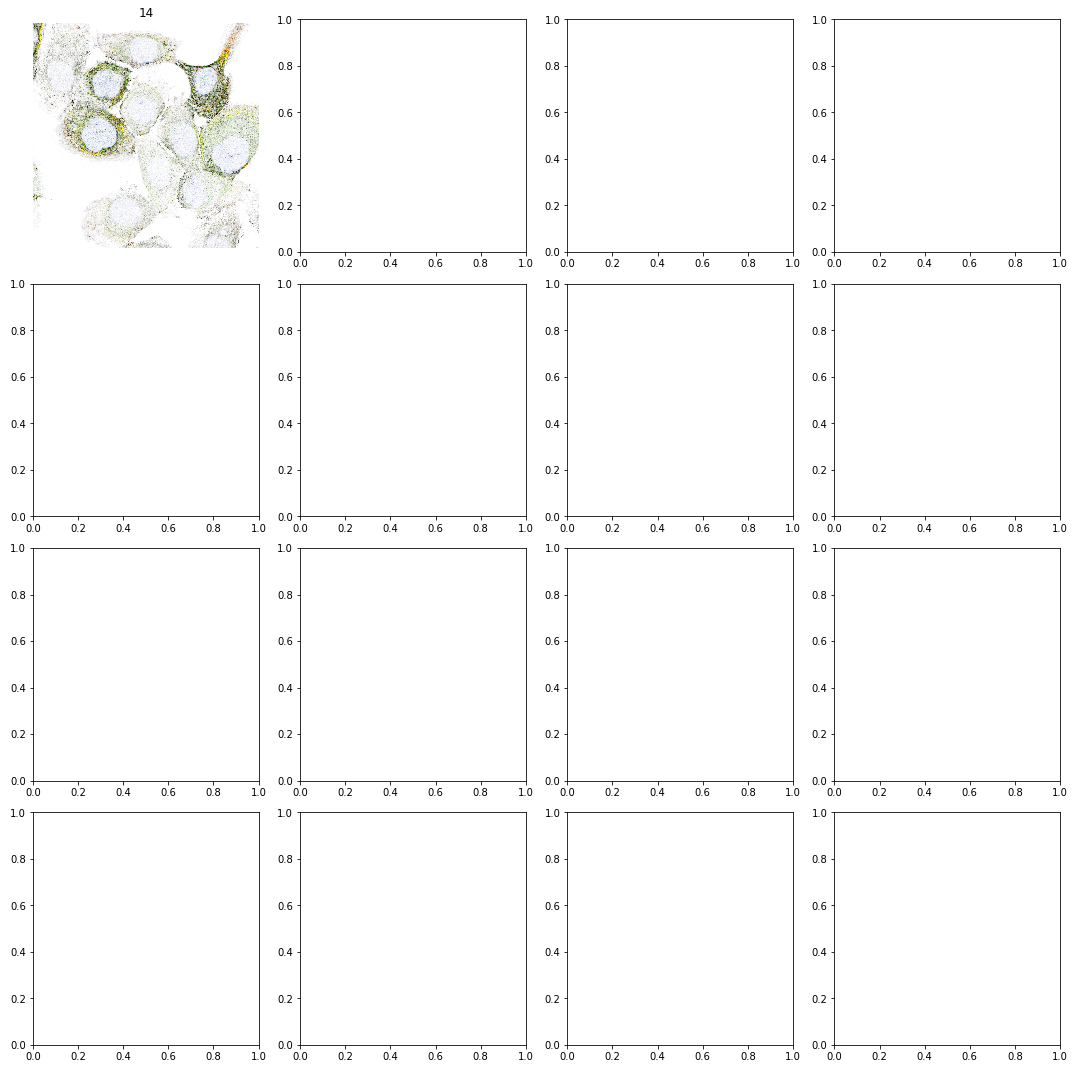

In [204]:
db.show_batch(rows=4, figsize=(15,15))

In [208]:
arch = wrn_22_4()

In [209]:
learn = Learner(db, arch , metrics=[accuracy_thresh, f1]);

In [210]:
%time learn.fit_one_cycle(1, 1e-2/10)

epoch,train_loss,valid_loss,accuracy_thresh,f1


RuntimeError: CUDA error: out of memory

# Training

In [52]:
def get_data(sz=64, bs=64):
    folder=TRAIN
    test_ds=None
    test_ds = Image4C_ds.from_single_folder(test_fnames, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)


In [195]:
arch = wrn_22_4()

In [27]:
def get_learner(data, loss=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1])
    if loss: learn.loss_func=FocalLoss()
    if fp16: learn.to_fp16();
    return learn

In [29]:
data = get_data(512,4)
learn = get_learner(data, True, True)

In [30]:
learn.load('wrn4_256')

In [31]:
%time learn.fit_one_cycle(4, 1e-2/10)

epoch,train_loss,valid_loss,accuracy_thresh,f1


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/

KeyboardInterrupt: 

In [21]:
learn.save('wrn4_512')

In [ ]:
%time learn.fit_one_cycle(10, 1e-2/3)

epoch,train_loss,valid_loss,accuracy_thresh,f1
